# Data Processing - Project 3
*Student*: **Chi Cong Nguyen** - *ID*: **295456** <br>
*Student*: **Karol Malinowski** - *ID*: **301759** <br>

## **I. Data description**

The aim of this project is to analyze data from 3 forums: **Politics**, **Travel**, and **Biology** in *Stack Exchange* website. After downloading and extracting all 3 zip files into 3 folders, we use the code created from the 2nd project and convert those xml files to DataFrame type in Python to analyze/

## **II. Loading data:**

We use code taken from 2nd project to load data:

In [2]:
import pandas as pd
import numpy as np
import ast
import os
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import webbrowser
from folium.plugins import TimestampedGeoJson
from datetime import datetime
from xml.etree.ElementTree import parse
from IPython.display import display

MAIN_DIR = r''
POLITICS_DIR =  'politics.stackexchange.com'
TRAVEL_DIR = 'travel.stackexchange.com'
BIOLOGY_DIR = 'biology.stackexchange.com' 

# Months array - used in graph plotting for posts summary
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

TABLES = ['Badges.xml', 'Comments.xml', 'PostHistory.xml', 'PostLinks.xml', 
          'Posts.xml', 'Tags.xml', 'Users.xml', 'Votes.xml']

BADGES_COLS = ['Id', 'TagBased', 'UserId', 'Class', 'Date', 'Name']
COMMENTS_COLS = ['Id', 'Score', 'ContentLicense', 'UserDisplayName', 'CreationDate', 'PostId', 'UserId', 'Text']
POSTHISTORY_COLS = ['Comment', 'Id', 'RevisionGUID', 'ContentLicense', 'UserDisplayName', 'CreationDate', 'PostId', 'UserId', 'Text', 'PostHistoryTypeId']
POSTLINKS_COLS = ['Id', 'CreationDate', 'RelatedPostId', 'PostId', 'LinkTypeId']
POSTS_COLS = ['Id', 'Score', 'OwnerUserId', 'ClosedDate', 'ViewCount', 'Title',
       'ContentLicense', 'LastEditDate', 'CommunityOwnedDate', 'CommentCount',
       'OwnerDisplayName', 'ParentId', 'AnswerCount', 'AcceptedAnswerId',
       'CreationDate', 'Body', 'LastEditorDisplayName', 'FavoriteCount',
       'PostTypeId', 'LastActivityDate', 'LastEditorUserId', 'Tags']
TAGS_COLS = ['Id', 'WikiPostId', 'TagName', 'Count', 'ExcerptPostId']
USERS_COLS = ['Id', 'LastAccessDate', 'AccountId', 'DownVotes', 'Reputation', 'UpVotes', 'Location', 'WebsiteUrl', 'ProfileImageUrl', 'AboutMe', 'Views', 'CreationDate', 'DisplayName']
VOTES_COLS = ['Id', 'CreationDate', 'PostId', 'UserId', 'VoteTypeId', 'BountyAmount']

COLS_DICT = {'Badges': BADGES_COLS,
            'Comments': COMMENTS_COLS,
            'PostHistory': POSTHISTORY_COLS,
            'PostLinks': POSTLINKS_COLS, 
            'Posts': POSTS_COLS,
            'Tags': TAGS_COLS,
            'Users': USERS_COLS,
            'Votes': VOTES_COLS}

pd.options.display.float_format = "{:.2f}".format

def tryeval(val):
    try:
        val = ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        try:
            val = datetime.strptime(val, '%Y-%m-%dT%H:%M:%S.%f')
        except ValueError:
            pass
    return val

def getMaxColumns(root):
    colsSet = set()
    for node in root: 
        currentNodeKeys = set(node.keys())
        colsSet = colsSet | currentNodeKeys
    return list(colsSet)
      
def parseXML2DataFrame(path, cols = []):
    root = parse(path).getroot()
    rows = []
    if len(cols) == 0:
        cols = getMaxColumns(root)
  
    for node in root: 
        res = []
        for el in cols[0:]: 
            cellValue = node.attrib.get(el)
            if node is not None and cellValue is not None:
                res.append(tryeval(cellValue))
            else: 
                res.append(np.NAN)
        rows.append({cols[i]: res[i] 
                    for i, _ in enumerate(cols)})
    return pd.DataFrame(rows, columns=cols)

def parseManyXML(directory):
    listOfDataFrames = {}
    for fn in os.listdir(directory):
        fileName = os.path.join(directory, fn)
        fileNameWithoutExt = os.path.splitext(fn)[0]
        df = parseXML2DataFrame(fileName, COLS_DICT[fileNameWithoutExt])
        listOfDataFrames[fileNameWithoutExt] = df
    return listOfDataFrames

def printDataSet(ds):
    for key in ds:
        print(key)
        display(ds[key].info())
        display(ds[key].head(10))
        print('\n')
        
BIOLOGY = parseManyXML(os.path.join(MAIN_DIR, BIOLOGY_DIR))
POLITICS = parseManyXML(os.path.join(MAIN_DIR, POLITICS_DIR))
TRAVEL = parseManyXML(os.path.join(MAIN_DIR, TRAVEL_DIR))

## **III. Q&A session:**

### 1. How the number of covid-19 related posts of every month in 2020 look like? 

In [37]:
def returndate(i, year):
    """Returns pandas datetime object depending on 'i'th month."""
    if i>12:
        return pd.to_datetime(str(year+1)+'-'+str(1)+'-01')
    else:
        return pd.to_datetime(str(year)+'-'+str(i)+'-01')

def ShowMonthlyPosts(df_pol, df_bio, df_trav, year):
    """Returns a barplot summary of comments number per month for each forum"""
    comment_rows = list()
    for i in range(2,14):
        post_row = list()
        
        p_filter = (df_pol['CreationDate'] >= returndate(i-1,year)) & (df_pol['CreationDate']< returndate(i,year))
        p_row = df_pol.loc[p_filter]
        post_row.append(len(p_row))
        
        t_filter = (df_trav['CreationDate'] >= returndate(i-1,year)) &(df_trav['CreationDate']< returndate(i,year))
        t_row = df_trav.loc[t_filter]
        post_row.append(len(t_row))

        b_filter = (df_bio['CreationDate'] >= returndate(i-1,year)) & (df_bio['CreationDate']< returndate(i,year))
        b_row = df_bio.loc[b_filter]
        post_row.append(len(b_row))
        
        comment_rows.append(post_row)
        #Transposes obtained array to fit into the graph


    comment_rows = list(map(list, zip(*comment_rows)))

    covid_per_month = pd.DataFrame({'Politics': comment_rows[0],
                       'Travel': comment_rows[1],
                       'Biology':comment_rows[2]
                       }, index=months)
    stats = covid_per_month.plot.bar(rot=0,figsize=(12,5))
    return stats

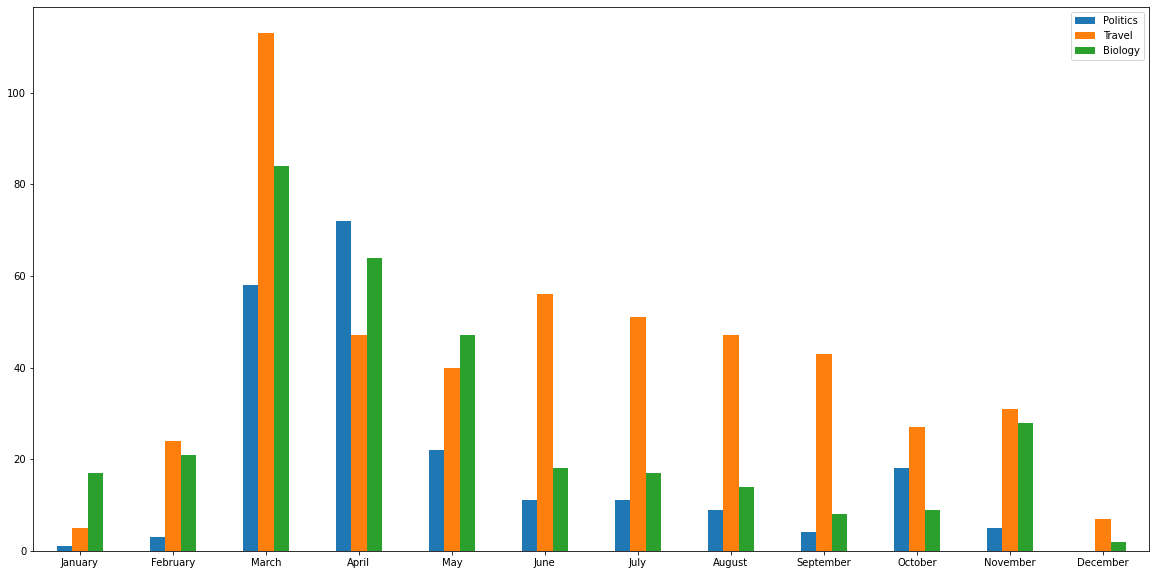

In [8]:
#COVID RELATED POSTS COUNT BY MONTHS IN 2020
biology_Posts = BIOLOGY['Posts']
politics_Posts = POLITICS['Posts']
travel_Posts = TRAVEL['Posts']

covid_politics = politics_Posts[politics_Posts['Tags'].str.contains('covid-19-virus',na=False)]
covid_biology = biology_Posts[biology_Posts['Tags'].str.contains('vaccination|coronavirus|virus|infectious-diseases|virology|epidemiology',na=False)]
covid_travel = travel_Posts[travel_Posts['Tags'].str.contains('covid-19|pandemics|vaccinations',na=False)]

covid_comment_stats = ShowMonthlyPosts(covid_politics,covid_biology,covid_travel)

   The graph above depicts how the distribution of posts on each forum per month looks like. The coronavirus outbreak had an extreme influence on the whole world almost every area of our lives. Starting from moving around the world and transit between countries. The first wave of the covid-19 virus in many european countries and USA can be estimated to appear in March, where governments put restrictions on the society in order to prevent the spread of virus. <br><br>
   From the collected data we can see that as 2020 started virus-related topics were on rise in biology and travel forums reaching peak value in March. As the virus prevented people from travelling into some countries users were active in forums most likely to seek answers how some countries are influenced by the epidemic. April is a next month when governments imposed much larger restrictions on citizens and development of a vaccine was a hot topic. When it comes to the rest of the year we can see a decline in the amount of posts in the rest of the forums while travel forum staying on a level approximately equal to the half of the peak in March. This relative high level of covid-19 related posts might be motivated by constant movement restrictions imposed by governments and incoming lockdown announcements.

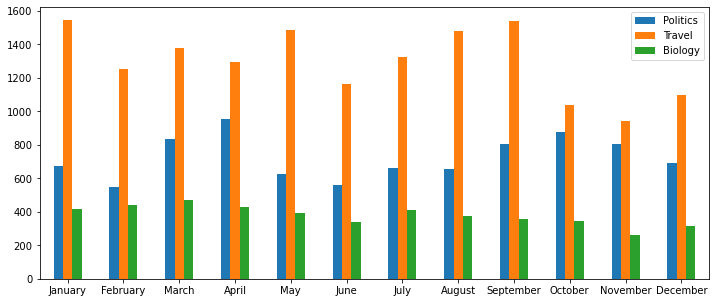

In [39]:
stat_2019 = ShowMonthlyPosts(politics_Posts,biology_Posts,travel_Posts,2019)

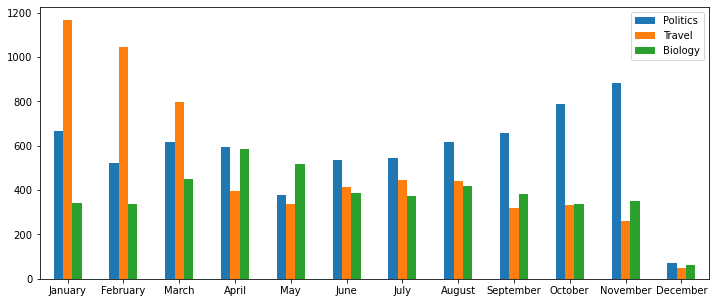

In [40]:
stat_2020 = ShowMonthlyPosts(politics_Posts,biology_Posts,travel_Posts,2020)

### Covid-related topics compared to non-related topics on each forum

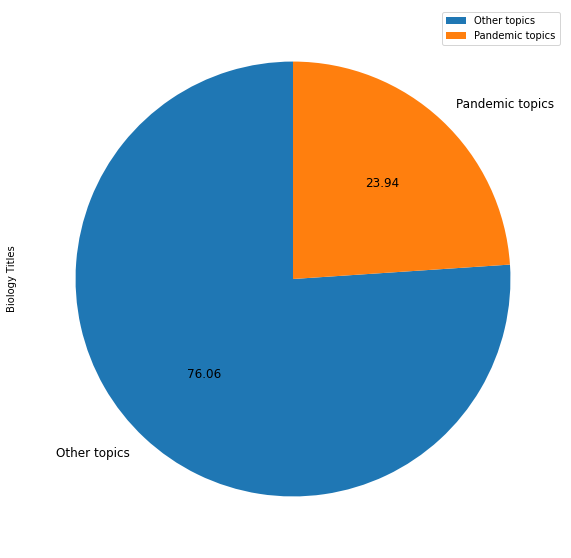

In [24]:
#BIOLOGY TOPICS DISTRIBUTION
biology_Tags = BIOLOGY['Tags']
bio_posts = biology_Posts['CreationDate'] >= '2020-01-01'
bio_2020 = biology_Posts.loc[bio_posts]

covid_bio_nr = biology_Tags[biology_Tags['TagName'].isin(['vaccination',
                                                          'coronavirus','virus','infectious-diseases',
                                                          'virology','epidemiology'])]
covid_bio_nr= sum(covid_bio_nr['Count'])

bio_data = pd.DataFrame({'Biology Titles': [len(bio_2020)-covid_bio_nr, covid_bio_nr]},
                  index=['Other topics', 'Pandemic topics',])

bio_plot = bio_data.plot.pie(fontsize=12,autopct='%.2f',y='Biology Titles', figsize=(10,10),startangle=90)


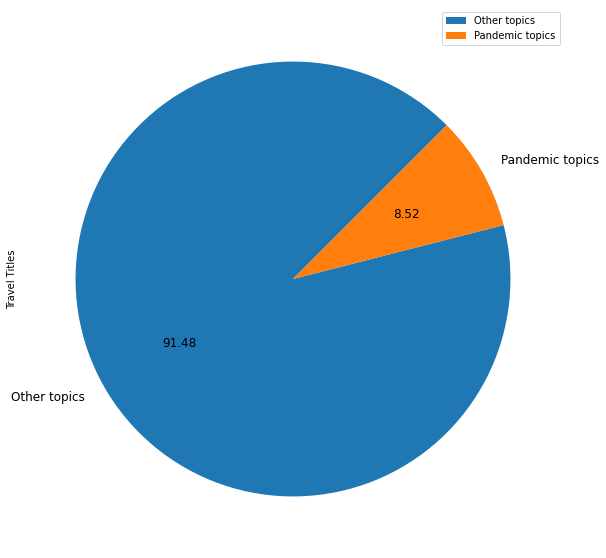

In [25]:
#TRAVEL TOPICS DISTRIBUTION
travel_Tags = TRAVEL['Tags']
trav_posts = travel_Posts['CreationDate'] >= '2020-01-01'
trav_2020 = travel_Posts.loc[trav_posts]

covid_trav_nr = travel_Tags[travel_Tags['TagName'].isin(['covid-19','pandemics','vaccinations'])]
covid_trav_nr= sum(covid_trav_nr['Count'])

trav_data = pd.DataFrame({'Travel Titles': [len(trav_2020)-covid_trav_nr, covid_trav_nr]},
                  index=['Other topics', 'Pandemic topics',])

trav_plot = trav_data.plot.pie(fontsize=12,autopct='%.2f',y='Travel Titles', figsize=(10,10),startangle=45)


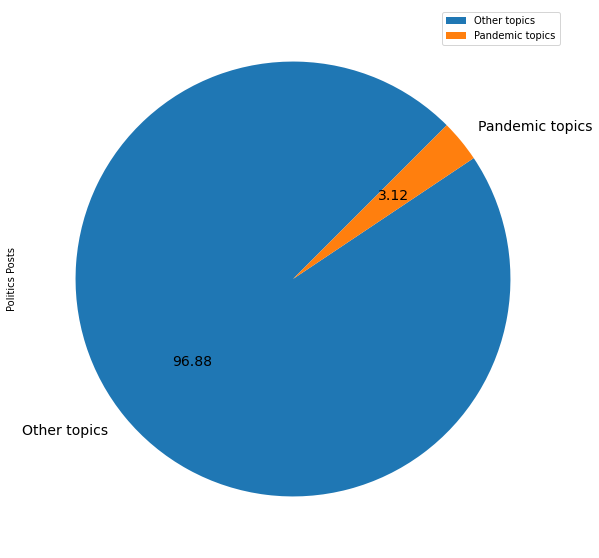

In [26]:
#POLITICS TOPICS DISTRIBUTION
politics_Tags = POLITICS['Tags']
pol_posts = politics_Posts['CreationDate'] >= '2020-01-01'
posts_2020 = politics_Posts.loc[pol_posts]

covid_posts_nr = politics_Tags[politics_Tags['TagName']=="covid-19-virus"]
covid_posts_nr = covid_posts_nr.iloc[0][3]

comp_data = pd.DataFrame({'Politics Posts': [len(posts_2020)-int(covid_posts_nr), int(covid_posts_nr)]},
                  index=['Other topics', 'Pandemic topics',])
plot = comp_data.plot.pie(fontsize=14,autopct='%.2f',y='Politics Posts', figsize=(10,10),startangle=45)

### 2. How are number of views of Covid-Questions related to number of answers?

In [28]:
def viewsAns(posts):
    return posts[['ViewCount', 'AnswerCount']].drop_duplicates().reset_index(drop=True)

# FILTER 'QUESTION' POSTS WHICH WERE CREATED LATER THAN 2020-01-01
b_posts_questions = BIOLOGY['Posts'][BIOLOGY['Posts'].OwnerUserId.notnull() & BIOLOGY['Posts'].PostTypeId == 1]
p_posts_questions = POLITICS['Posts'][POLITICS['Posts'].OwnerUserId.notnull() & POLITICS['Posts'].PostTypeId == 1]
t_posts_questions = TRAVEL['Posts'][TRAVEL['Posts'].OwnerUserId.notnull() & TRAVEL['Posts'].PostTypeId == 1]

b_posts_questions = b_posts_questions.loc[b_posts_questions['CreationDate'] >= '2020-01-01']
p_posts_questions = p_posts_questions.loc[p_posts_questions['CreationDate'] >= '2020-01-01']
t_posts_questions = t_posts_questions.loc[t_posts_questions['CreationDate'] >= '2020-01-01']

# FILTER 'QUESTION' POSTS WHICH WERE CREATED LATER THAN 2020-01-01 AND WITH COVID-RELATED TAGS
b_posts_question_covid = b_posts_questions[b_posts_questions['Tags'].str.contains('vaccination|coronavirus|virus|infectious-diseases|virology|epidemiology',na=False)]
p_posts_question_covid = p_posts_questions[p_posts_questions['Tags'].str.contains('covid-19-virus',na=False)]
t_posts_questions_covid = t_posts_questions[t_posts_questions['Tags'].str.contains('covid-19|pandemics|vaccinations',na=False)]

# GET VIEW-COUNT AND ANSWER-COUNT OF FILTERED POSTS
b_posts_viewAns = viewsAns(b_posts_questions)
p_posts_viewAns = viewsAns(p_posts_questions)
t_posts_viewAns = viewsAns(t_posts_questions)

b_posts_viewAns_covid = viewsAns(b_posts_question_covid)
p_posts_viewAns_covid = viewsAns(p_posts_question_covid)
t_posts_viewAns_covid = viewsAns(t_posts_questions_covid)

After getting data for number of views and answers for each question which related to Covid-19, we try to analyze them:

In [29]:
display(b_posts_viewAns_covid.describe())

,ViewCount,AnswerCount
count,226.00,226.00
mean,859.66,1.09
std,2718.36,0.96
min,9.00,0.00
25%,45.25,0.00
50%,81.50,1.00
75%,165.50,2.00
max,23477.00,5.00


From the table of Biology forum, we can have some observations:
* 50% of Covid-19-related questions took around 82 views to obtain an average of 1 answers.
* 75% of Covid-19-related questions took around 166 views to obtain an average of 2 answers.
* A Covid-19-related question took about 860 views to get 1 answer.

In [10]:
display(p_posts_viewAns_covid.describe())

,ViewCount,AnswerCount
count,197.00,197.00
mean,1649.92,2.19
std,3307.93,2.08
min,45.00,0.00
25%,162.00,1.00
50%,275.00,1.00
75%,830.00,3.00
max,18297.00,10.00


From the table of Politics forum, we can have some observations:
* 50% of Covid-19-related questions took around 82 views to obtain an average of 1 answers.
* 75% of Covid-19-related questions took around 830 views to obtain an average of 3 answers.
* A Covid-19-related question took about 1649 views to get 2 answers.

In [11]:
display(t_posts_viewAns_covid.describe())

,ViewCount,AnswerCount
count,405.00,405.00
mean,1220.11,1.38
std,3626.09,1.25
min,12.00,0.00
25%,131.00,1.00
50%,233.00,1.00
75%,596.00,2.00
max,51234.00,9.00


From the table of Travel forum, we can have some observations:
* 25% of Covid-19-related questions took around 131 views to obtain an average of 1 answers.
* 50% of Covid-19-related questions took around 233 views to obtain an average of 1 answers.
* 75% of Covid-19-related questions took around 596 views to obtain an average of 2 answers.
* A Covid-19-related question took about 1220 views to get about 1 answer.

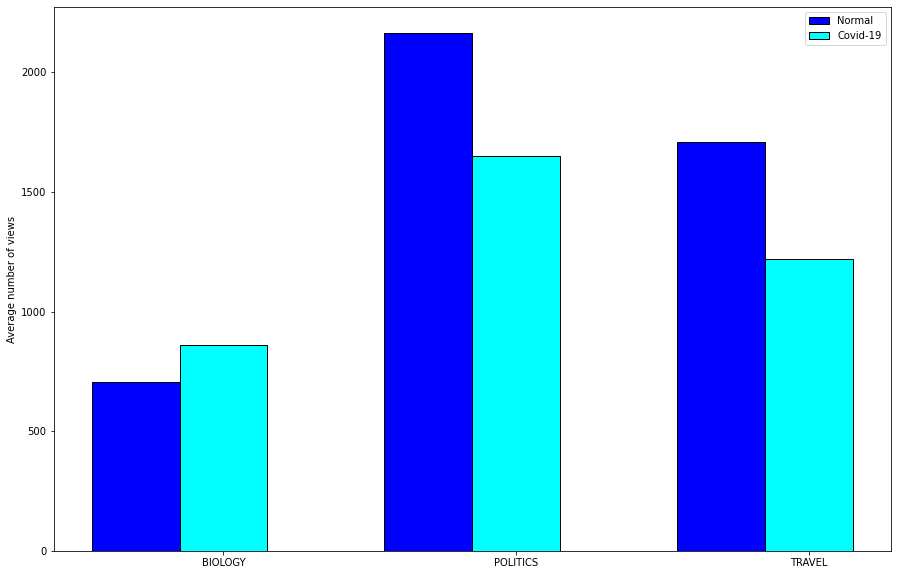

In [30]:
b_avg_views = np.mean(b_posts_viewAns['ViewCount'])
p_avg_views = np.mean(p_posts_viewAns['ViewCount'])
t_avg_views = np.mean(t_posts_viewAns['ViewCount'])

b_avg_views_covid = np.mean(b_posts_viewAns_covid['ViewCount'])
p_avg_views_covid = np.mean(p_posts_viewAns_covid['ViewCount'])
t_avg_views_covid = np.mean(t_posts_viewAns_covid['ViewCount'])

normal = [b_avg_views, p_avg_views, t_avg_views]
covid = [b_avg_views_covid, p_avg_views_covid, t_avg_views_covid]

# width of the bars
barWidth = 0.3

# The x position of bars
r1 = np.arange(len(normal))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(15,10))
# Create blue bars
plt.bar(r1, normal, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Normal')
 
# Create cyan bars
plt.bar(r2, covid, width = barWidth, color = 'cyan', edgecolor = 'black', capsize=7, label='Covid-19')
 
# general layout
plt.xticks([r + barWidth for r in range(len(normal))], ['BIOLOGY', 'POLITICS', 'TRAVEL'])
plt.ylabel('Average number of views')
plt.legend()
# Show graphic
plt.show()

### 3. How number of Covid posts relate to Covid-cases in each state?

#### a) Load data about Covid-19 cases and the US' states with their longtitude and latitude:

In [31]:
#3.1 Data for covid-cases
FILE_NAME = 'mymap.html'
latitude = 39
longitude = -105
recentDate = datetime.strptime('21-01-29', '%y-%m-%d')
data_covid = pd.read_csv("us-states.csv",  parse_dates=['date'], date_parser=pd.to_datetime)
us_states = pd.read_csv("states.csv")[:52]

#### b) Filter posts data frames from 3 forum which have covid-19 related tags:

In [32]:
b_posts = BIOLOGY['Posts'].loc[BIOLOGY['Posts'].OwnerUserId.notnull()]
b_posts = b_posts[b_posts['Tags'].str.contains('vaccination|coronavirus|virus|infectious-diseases|virology|epidemiology',na=False)]
b_posts = b_posts.loc[b_posts['CreationDate'] >= '2020-01-01']

p_posts = POLITICS['Posts'][POLITICS['Posts'].OwnerUserId.notnull()]
p_posts = p_posts[p_posts['Tags'].str.contains('covid-19-virus',na=False)]
p_posts = p_posts.loc[p_posts['CreationDate'] >= '2020-01-01']

t_posts = TRAVEL['Posts'][TRAVEL['Posts'].OwnerUserId.notnull()]
t_posts = t_posts[t_posts['Tags'].str.contains('covid-19|pandemics|vaccinations',na=False)]
t_posts = t_posts.loc[t_posts['CreationDate'] >= '2020-01-01']


b_users = BIOLOGY['Users'].loc[BIOLOGY['Users'].Location.notnull(), ['Id', 'Location']]
p_users = POLITICS['Users'].loc[POLITICS['Users'].Location.notnull(), ['Id', 'Location']]
t_users = TRAVEL['Users'].loc[TRAVEL['Users'].Location.notnull(), ['Id', 'Location']] 

We have to map the Location of the user to the correct state, just so we can plot it in the map:

In [33]:
def get_state(x):
    for index, row in us_states.iterrows():
        x = str(x)
        if (row['name'] in x) or (row['state'] in x):
            return row['name']
    return np.nan

b_users['Location'] = list(map(get_state, b_users['Location']))
p_users['Location'] = list(map(get_state, p_users['Location']))
t_users['Location'] = list(map(get_state, t_users['Location']))
    
b_users = b_users[b_users.Location.notnull()]
p_users = p_users[p_users.Location.notnull()]
t_users = t_users[t_users.Location.notnull()]

Now we merge covid-19 related posts and user table to know what those posts come from:

In [34]:
b_posts_users = pd.merge(
    b_posts,  
    b_users,
    left_on = ['OwnerUserId'],
    right_on = ['Id']
)[['Location']].reset_index(drop=True)\
    .groupby('Location') \
    .size().to_frame('Total').reset_index() \
    .rename(columns={'Location':'state'}) 
b_posts_users = pd.merge(
    b_posts_users,  
    us_states,
    left_on = ['state'],
    right_on = ['name'],
    how = 'left'
)[['name', 'Total', 'latitude', 'longitude']].reset_index(drop=True)

p_posts_users = pd.merge(
    p_posts,  
    p_users,
    left_on = ['OwnerUserId'],
    right_on = ['Id']
)[['Location']].reset_index(drop=True)\
    .groupby('Location') \
    .size().to_frame('Total').reset_index() \
    .rename(columns={'Location':'state'}) 
p_posts_users = pd.merge(
    p_posts_users,  
    us_states,
    left_on = ['state'],
    right_on = ['name'],
    how = 'left'
)[['name', 'Total', 'latitude', 'longitude']].reset_index(drop=True)


t_posts_users = pd.merge(
    t_posts,  
    t_users,
    left_on = ['OwnerUserId'],
    right_on = ['Id']
)[['Location']].reset_index(drop=True)\
    .groupby('Location') \
    .size().to_frame('Total').reset_index() \
    .rename(columns={'Location':'state'}) 
t_posts_users = pd.merge(
    t_posts_users,  
    us_states,
    left_on = ['state'],
    right_on = ['name'],
    how = 'left'
)[['name', 'Total', 'latitude', 'longitude']].reset_index(drop=True)

Now, we try to present covid-data in the map:

In [42]:
m = folium.Map(location=[latitude, longitude], zoom_start=5)
df = data_covid.loc[data_covid['date'] == recentDate, ['state', 'cases']].groupby(['state']).sum().reset_index()
df = pd.merge(df, 
    us_states[['name','latitude', 'longitude']], 
    left_on = ['state'],
    right_on = ['name'])

for i in range(0,len(b_posts_users)):
    folium.Circle(
      [b_posts_users.iloc[i]['latitude'], b_posts_users.iloc[i]['longitude']],
      radius=b_posts_users.iloc[i]['Total']*10000.0,
      color='blue',
      fill=True,
      fill_color='blue'
    ).add_to(m)
    
for i in range(0,len(p_posts_users)):
    folium.Circle(
      [p_posts_users.iloc[i]['latitude'], p_posts_users.iloc[i]['longitude']],
      radius=p_posts_users.iloc[i]['Total']*10000.0,
      color='green',
      fill=True,
      fill_color='green'
    ).add_to(m)
    
for i in range(0,len(t_posts_users)):
    folium.Circle(
      [t_posts_users.iloc[i]['latitude'], t_posts_users.iloc[i]['longitude']],
      radius=t_posts_users.iloc[i]['Total']*10000.0,
      color='yellow',
      fill=True,
      fill_color='yellow'
    ).add_to(m)
 
for i in range(0,len(df)):
    folium.Circle(
      [df.iloc[i]['latitude'], df.iloc[i]['longitude']],
      popup=('<b>' + str(df.iloc[i]['name']) + '</b> <br>'
              'Cases: ' + format(df.iloc[i]['cases'], ',')
            ),
      radius=df.iloc[i]['cases']*0.1,
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)   

m.save(FILE_NAME)
m
#webbrowser.open(FILE_NAME, new=2)

## **C. References**

* Stack Exchange Data Dump <br>
https://archive.org/details/stackexchange

* US States with `latitude` and `longitude` <br>
<https://developers.google.com/public-data/docs/canonical/states_csv>

* Coronavirus Source Data <br/>
https://ourworldindata.org/coronavirus-source-data